In [2]:
!pip install yfinance
import pandas as pd
import numpy as np
import yfinance as yf
import os
import scipy
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.utils import resample
import warnings
import pickle

CODE2STOCK={"UA":"UAL","AA":"AAL","AS":"ALK","B6":"JBLU","DL":"DAL","HA":"HA","NK":"SAVE","OO":"SKYW","WN":"LUV","G4":"ALGT"}
NO_STOCK=["EV","VX","9E","MQ","OH","YX","QX","F9","YV"]
NO_1HOT_COLS=["AIR_STOCK","DOW","NASDAQ","DEP_TIME","CRS_DEP_TIME","DEP_DELAY","DEP_DELAY_NEW","DEP_DEL15","TAXI_OUT","WHEELS_OFF","WHEELS_ON","TAXI_IN","CRS_ARR_TIME","ARR_TIME","ARR_DELAY","ARR_DELAY_NEW","ARR_DEL15","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","AIR_TIME","FLIGHTS","DISTANCE"]
EX_BANNED=['DEP_TIME','DEP_DELAY','TAXI_OUT','WHEELS_OFF']
NEW_COLS=['NASDAQ','DOW','AIR_STOCK']

def _clean_bts_data(input_dir_path="./raw_bts_data",output_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\bts_data.csv"):
    df=None
    for f in os.listdir(input_dir_path):
        p = os.path.join(input_dir_path, f)
        if(type(df)==None):
            df=pd.read_csv(p)
        else:
            df=pd.concat([df,pd.read_csv(p)])
    df=df.dropna()
    for s in NO_STOCK:
        df=df[df["OP_UNIQUE_CARRIER"]!=s]
    df.to_csv(output_path,index=False)    

def _get_dow(input_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\raw_stock_data.zip\\raw_stock_data\\dow_data.csv"):
    df=pd.read_csv(input_path)
    df["Stock"]="DOW"
    df["YEAR"]=df.apply(lambda row: int(row["Date"].split("/")[2]),axis=1)
    df["MONTH"]=df.apply(lambda row: int(row["Date"].split("/")[0]),axis=1)
    df["DAY_OF_MONTH"]=df.apply(lambda row: int(row["Date"].split("/")[1]),axis=1)
    df=df.drop("Date",axis=1)
    return df

def _clean_stock_data(input_dow_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\raw_stock_data.zip\\raw_stock_data\\dow_data.csv",output_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\raw_stock_data.zip\\raw_stock_data\\dow_data.csv"):
    ranges=[("2017-12-01","2017-12-31"),
            ("2018-12-01","2018-12-31"),
            ("2019-12-01","2019-12-31"),
            ("2020-12-01","2020-12-31"),
            ("2021-12-01","2021-12-31"),
            ]
    stocks=list(CODE2STOCK.values())
    stocks.append("^IXIC")
    data=None
    for stock in stocks:
        for range in ranges:
            new = yf.download(stock, start=range[0], end=range[1])
            new["Stock"]=stock
            if(type(data)==None):
                data=new
            else:
                data=pd.concat([data,new])
    data=data.reset_index()
    data=data[["Date","Close","Stock"]]
    data["YEAR"]=data.apply(lambda row: row["Date"].year,axis=1)
    data["MONTH"]=data.apply(lambda row: row["Date"].month,axis=1)
    data["DAY_OF_MONTH"]=data.apply(lambda row: row["Date"].day,axis=1)
    data=data.drop("Date",axis=1)
    dow=_get_dow(input_dow_path)
    df=pd.concat([data,dow])
    df.to_csv(output_path,index=False)

def _match_stock(row,stock,stock_name):
    vals=stock[(stock["YEAR"]==row["YEAR"]) & (stock["MONTH"]==row["MONTH"]) & (stock["DAY_OF_MONTH"]==row["DAY_OF_MONTH"]) & (stock["Stock"]==stock_name)]["Close"].values
    if(len(vals)==0):
        return pd.NA
    else:
        return vals[0]

def _merge_bts_stock(bts_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\bts_data.csv",stock_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\stock_data.csv",output_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\all_data.csv"):
    bts=pd.read_csv(bts_path)
    stock=pd.read_csv(stock_path)
    bts["NASDAQ"]=bts.apply(lambda row: _match_stock(row,stock,"^IXIC"),axis=1)
    bts["DOW"]=bts.apply(lambda row: _match_stock(row,stock,"DOW"),axis=1)
    bts["AIR_STOCK"]=bts.apply(lambda row: _match_stock(row,stock,CODE2STOCK[row["OP_UNIQUE_CARRIER"]]),axis=1)
    df=bts.dropna()
    df.to_csv(output_path,index=False)

def _final_clean(output_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\all_data.csv"):
    df=load_data(separate=False)
    for col in df.columns:
        if(len(df[col].unique())<=1):
            df=df.drop(col,axis=1)
    df=df.drop(EX_BANNED,axis=1)
    df.to_csv(output_path,index=False)

def _preproc_features(df,save=False):
    cols=df.columns
    cols=[col for col in cols if col not in NO_1HOT_COLS]
    enc=OneHotEncoder().fit(df[cols])
    df1=enc.transform(df[cols])
    df2=df.drop(cols,axis=1)
    if(save):
        with open('./preproc.sav', 'wb') as file:
            pickle.dump({'enc':enc,'mean':df2.mean(),'std':df2.std()}, file)
    df2=(df2-df2.mean())/df2.std()
    df2=scipy.sparse.csr_matrix(df2.values)
    sp=scipy.sparse.hstack([df1,df2])
    return sp.astype(np.float32)

def _preproc_labels(df):
    return df["ARR_DEL15"].to_numpy(dtype=np.longlong)

def _resample(df):
    pos=df[df['ARR_DEL15']==1]
    neg=df[df['ARR_DEL15']==0]
    if(len(pos)>len(neg)):
        return pd.concat([neg,resample(pos, replace=False, n_samples=len(neg))])
    else:
        return pd.concat([pos,resample(neg, replace=False, n_samples=len(pos))])
    
def _subsample(df,perc):
    return resample(df, replace=False, n_samples=round(len(df)*perc))

def _no_covid_data(df):
    return df[df['YEAR']<2020]

def _covid_data(df):
    return df[df['YEAR']>=2020]

def preproc_features_df(df,ordinal=False):
    cols=df.columns
    cols=[col for col in cols if col not in NO_1HOT_COLS]
    if(ordinal):
        enc=OrdinalEncoder().set_output(transform="pandas")
        df1=enc.fit_transform(df[cols])
        return pd.concat([df1,df.drop(cols,axis=1)],axis=1)
    for col in cols:
        one_hot = pd.get_dummies(df[col],prefix=col)
        df = df.drop(col,axis = 1)
        df = df.join(one_hot)
    return df

def preproc_labels_df(df):
    return df["ARR_DEL15"]

def feature_label_split(df):
    labels=df["ARR_DEL15"].to_frame()
    features=df.drop("ARR_DEL15",axis=1)
    return features,labels

def preproc_data(features, labels):
    return _preproc_features(features),_preproc_labels(labels)

def load_data(input_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\all_data.csv",*,separate=True,resample=False,subsample=1.0,bts_only=False,covid=None,stock_only=False,select_features=False):
    df=pd.read_csv(input_path)
    if(select_features):
        df=df[['DAY_OF_MONTH','OP_UNIQUE_CARRIER','ORIGIN_AIRPORT_ID',
           'DEST_AIRPORT_ID','CRS_DEP_TIME', 'ARR_DEL15','NASDAQ', 'DOW', 'AIR_STOCK']]
    if(stock_only):
        nc=NEW_COLS
        nc.append('ARR_DEL15')
        df=df[nc]
    if(covid==True):
        df=_covid_data(df)
    elif(covid==False):
        df=_no_covid_data(df)
    if(bts_only):
        df=df.drop(NEW_COLS,axis=1)
    if(subsample != 1.0):
        df=_subsample(df,subsample)
    if(resample):
        df=_resample(df)
    if(separate==False):
        return df
    return feature_label_split(df)

def load_bts_data(input_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\all_data.csv",separate=True):
    warnings.warn('Deprecated and will be removed in a future version. Use load_data(bts_only=True) instead.')
    df=load_data(input_path,False)
    df=df.drop(NEW_COLS,axis=1)
    if(separate==False):
        return df
    return feature_label_split(df)

if __name__ == "__main__":
    pass

In [3]:
# Call the function without passing the separate argument
df = load_data()

# Call the function and pass the separate argument
df = load_data(separate=False)


In [4]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

# get the string columns
cat_cols = df.drop(columns=['ARR_DEL15', 'DISTANCE']).columns.tolist()


# Fit and transform the encoder on the selected columns
encoder = OrdinalEncoder()
encoded_cols = encoder.fit_transform(df[cat_cols])

# Convert the encoded columns to a DataFrame
encoded_df = pd.DataFrame(encoded_cols, columns=cat_cols)

# Concatenate the encoded columns with the remaining columns
df_encoded = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)

df_encoded

,ARR_DEL15,DISTANCE,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,...,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_CITY_NAME,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME,NASDAQ,DOW,AIR_STOCK
0,0.0,1158.0,0.0,0.0,4.0,0.0,115.0,2568.0,93.0,17.0,...,40.0,279.0,275.0,267.0,44.0,19.0,298.0,14.0,90.0,486.0
1,0.0,1158.0,0.0,0.0,4.0,0.0,115.0,2600.0,279.0,275.0,...,19.0,93.0,17.0,80.0,41.0,40.0,578.0,14.0,90.0,486.0
2,0.0,918.0,0.0,0.0,4.0,0.0,115.0,385.0,93.0,17.0,...,40.0,169.0,94.0,153.0,7.0,14.0,783.0,14.0,90.0,486.0
3,0.0,918.0,0.0,0.0,4.0,0.0,115.0,385.0,169.0,94.0,...,14.0,93.0,17.0,80.0,41.0,40.0,1038.0,14.0,90.0,486.0
4,0.0,1021.0,0.0,0.0,4.0,0.0,116.0,2194.0,70.0,55.0,...,24.0,93.0,17.0,80.0,41.0,40.0,558.0,14.0,90.0,486.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345612,1.0,353.0,4.0,28.0,3.0,9.0,5863.0,436.0,192.0,187.0,...,49.0,231.0,177.0,229.0,4.0,49.0,768.0,95.0,36.0,388.0
1345613,1.0,650.0,4.0,28.0,3.0,9.0,5863.0,436.0,202.0,211.0,...,33.0,23.0,33.0,22.0,41.0,40.0,498.0,95.0,36.0,388.0
1345614,1.0,353.0,4.0,28.0,3.0,9.0,5863.0,437.0,231.0,177.0,...,49.0,192.0,187.0,186.0,4.0,49.0,888.0,95.0,36.0,388.0
1345615,1.0,353.0,4.0,28.0,3.0,9.0,5863.0,438.0,192.0,187.0,...,49.0,231.0,177.0,229.0,4.0,49.0,1008.0,95.0,36.0,388.0


In [5]:
df_pre_covid = df_encoded[df_encoded['YEAR'].isin([0,1,2])]
df_post_covid= df_encoded[df_encoded['YEAR'].isin([3,4])]


In [6]:
import pandas as pd
# Determine the class with the fewer samples.
counts = df_post_covid['ARR_DEL15'].value_counts()
minority_class = counts.idxmin()
minority_count = counts[minority_class]

# Select a random sample of the larger class with the same size as the smaller class.
majority_class = 1 - minority_class
majority_count = counts[majority_class]
majority_sample = df_post_covid[df_post_covid['ARR_DEL15'] == majority_class].sample(n=minority_count, random_state=0)

# Combine the two classes into a single DataFrame.
minority_df = df_post_covid[df_post_covid['ARR_DEL15'] == minority_class]
balanced_df = pd.concat([minority_df, majority_sample], axis=0)

balanced_df

,ARR_DEL15,DISTANCE,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,...,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_CITY_NAME,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME,NASDAQ,DOW,AIR_STOCK
872555,1.0,912.0,3.0,0.0,1.0,0.0,155.0,199.0,72.0,86.0,...,17.0,156.0,111.0,143.0,41.0,40.0,993.0,60.0,0.0,11.0
872596,1.0,366.0,3.0,0.0,1.0,0.0,221.0,766.0,259.0,18.0,...,13.0,72.0,86.0,58.0,31.0,17.0,367.0,60.0,0.0,11.0
872614,1.0,986.0,3.0,0.0,1.0,0.0,255.0,2488.0,99.0,104.0,...,23.0,93.0,17.0,80.0,41.0,40.0,322.0,60.0,0.0,11.0
872677,1.0,2521.0,3.0,0.0,1.0,0.0,384.0,375.0,301.0,177.0,...,49.0,252.0,252.0,246.0,36.0,13.0,531.0,60.0,0.0,11.0
872678,1.0,1440.0,3.0,0.0,1.0,0.0,386.0,1909.0,253.0,38.0,...,41.0,239.0,78.0,62.0,11.0,21.0,438.0,60.0,0.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205539,0.0,486.0,4.0,14.0,2.0,9.0,4624.0,5873.0,2.0,7.0,...,46.0,180.0,163.0,176.0,26.0,45.0,308.0,91.0,25.0,328.0
1263853,0.0,447.0,4.0,21.0,2.0,0.0,425.0,370.0,93.0,17.0,...,40.0,228.0,231.0,219.0,16.0,38.0,1033.0,90.0,30.0,94.0
1030244,0.0,1032.0,3.0,26.0,0.0,2.0,1443.0,1444.0,149.0,132.0,...,12.0,332.0,210.0,319.0,7.0,14.0,733.0,78.0,4.0,27.0
1138359,0.0,917.0,4.0,7.0,2.0,9.0,4407.0,4619.0,332.0,210.0,...,14.0,87.0,17.0,79.0,41.0,40.0,913.0,98.0,53.0,444.0


# Creative

In [13]:
from utils import load_data
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

#df = load_data(separate=False)
df_stock_only = df[['AIR_STOCK','NASDAQ', 'DOW', 'ARR_DEL15']]


# get the string columns
cat_cols = df.drop(columns=['ARR_DEL15', 'DISTANCE', 'NASDAQ', 'DOW', 'AIR_STOCK']).columns.tolist()


# Fit and transform the encoder on the selected columns
encoder = OrdinalEncoder()
encoded_cols = encoder.fit_transform(df[cat_cols])

# Convert the encoded columns to a DataFrame
encoded_df = pd.DataFrame(encoded_cols, columns=cat_cols)

# Drop the original columns from the DataFrame
df = df.drop(columns=cat_cols)

# Concatenate the encoded columns with the remaining columns
df = pd.concat([df, encoded_df], axis=1)

df

,ARR_DEL15,DISTANCE,NASDAQ,DOW,AIR_STOCK,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,...,ORIGIN_CITY_MARKET_ID,ORIGIN_CITY_NAME,ORIGIN_STATE_FIPS,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_CITY_NAME,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME
0,0.0,1158.0,6847.589844,570.89,49.000000,0.0,0.0,4.0,0.0,115.0,...,17.0,80.0,41.0,40.0,279.0,275.0,267.0,44.0,19.0,298.0
1,0.0,1158.0,6847.589844,570.89,49.000000,0.0,0.0,4.0,0.0,115.0,...,275.0,267.0,44.0,19.0,93.0,17.0,80.0,41.0,40.0,578.0
2,0.0,918.0,6847.589844,570.89,49.000000,0.0,0.0,4.0,0.0,115.0,...,17.0,80.0,41.0,40.0,169.0,94.0,153.0,7.0,14.0,783.0
3,0.0,918.0,6847.589844,570.89,49.000000,0.0,0.0,4.0,0.0,115.0,...,94.0,153.0,7.0,14.0,93.0,17.0,80.0,41.0,40.0,1038.0
4,0.0,1021.0,6847.589844,570.89,49.000000,0.0,0.0,4.0,0.0,116.0,...,55.0,66.0,33.0,24.0,93.0,17.0,80.0,41.0,40.0,558.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345612,1.0,353.0,15741.559570,465.45,42.720001,4.0,28.0,3.0,9.0,5863.0,...,187.0,186.0,4.0,49.0,231.0,177.0,229.0,4.0,49.0,768.0
1345613,1.0,650.0,15741.559570,465.45,42.720001,4.0,28.0,3.0,9.0,5863.0,...,211.0,161.0,23.0,33.0,23.0,33.0,22.0,41.0,40.0,498.0
1345614,1.0,353.0,15741.559570,465.45,42.720001,4.0,28.0,3.0,9.0,5863.0,...,177.0,229.0,4.0,49.0,192.0,187.0,186.0,4.0,49.0,888.0
1345615,1.0,353.0,15741.559570,465.45,42.720001,4.0,28.0,3.0,9.0,5863.0,...,187.0,186.0,4.0,49.0,231.0,177.0,229.0,4.0,49.0,1008.0


In [14]:
import pandas as pd
# Determine the class with the fewer samples.
counts = df_stock_only['ARR_DEL15'].value_counts()
minority_class = counts.idxmin()
minority_count = counts[minority_class]

# Select a random sample of the larger class with the same size as the smaller class.
majority_class = 1 - minority_class
majority_count = counts[majority_class]
majority_sample = df_stock_only[df_stock_only['ARR_DEL15'] == majority_class].sample(n=minority_count, random_state=0)

# Combine the two classes into a single DataFrame.
minority_df = df_stock_only[df_stock_only['ARR_DEL15'] == minority_class]
balanced_df_stock_only = pd.concat([minority_df, majority_sample], axis=0)

minority_df = df[df['ARR_DEL15'] == minority_class]
majority_sample = df[df['ARR_DEL15'] == majority_class].sample(n=minority_count, random_state=0)
balanced_df = pd.concat([minority_df, majority_sample], axis=0)

balanced_df

,ARR_DEL15,DISTANCE,NASDAQ,DOW,AIR_STOCK,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,...,ORIGIN_CITY_MARKET_ID,ORIGIN_CITY_NAME,ORIGIN_STATE_FIPS,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_CITY_NAME,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME
11,1.0,1145.0,6847.589844,570.89,49.000000,0.0,0.0,4.0,0.0,121.0,...,178.0,200.0,7.0,14.0,99.0,104.0,87.0,20.0,23.0,688.0
20,1.0,204.0,6847.589844,570.89,49.000000,0.0,0.0,4.0,0.0,125.0,...,178.0,200.0,7.0,14.0,332.0,210.0,319.0,7.0,14.0,287.0
51,1.0,204.0,6847.589844,570.89,49.000000,0.0,0.0,4.0,0.0,146.0,...,210.0,319.0,7.0,14.0,214.0,178.0,200.0,7.0,14.0,600.0
58,1.0,590.0,6847.589844,570.89,49.000000,0.0,0.0,4.0,0.0,162.0,...,86.0,58.0,31.0,17.0,248.0,249.0,333.0,7.0,14.0,653.0
59,1.0,590.0,6847.589844,570.89,49.000000,0.0,0.0,4.0,0.0,162.0,...,249.0,333.0,7.0,14.0,72.0,86.0,58.0,31.0,17.0,807.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959215,0.0,864.0,12595.059570,331.28,44.160000,3.0,14.0,1.0,7.0,385.0,...,78.0,62.0,11.0,21.0,169.0,94.0,153.0,7.0,14.0,953.0
1320077,0.0,1721.0,15766.219727,468.55,18.049999,4.0,27.0,2.0,0.0,4316.0,...,78.0,62.0,11.0,21.0,299.0,43.0,298.0,45.0,51.0,833.0
1169049,0.0,812.0,15413.280273,462.84,17.120001,4.0,12.0,0.0,0.0,4312.0,...,17.0,80.0,41.0,40.0,83.0,204.0,64.0,15.0,27.0,613.0
651039,0.0,781.0,8621.830078,475.67,55.470001,2.0,8.0,0.0,9.0,2241.0,...,210.0,319.0,7.0,14.0,148.0,111.0,143.0,41.0,40.0,638.0


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(balanced_df_stock_only.drop(columns=['ARR_DEL15']), balanced_df_stock_only['ARR_DEL15'], test_size=0.2, stratify=balanced_df_stock_only['ARR_DEL15'], random_state=0)

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for MultinomialNB
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

# Create an instance of MultinomialNB
clf = MultinomialNB()

# Create a GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=3, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by the grid search
print("Best parameters:", grid_search.best_params_)



Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'alpha': 0.1}


Accuracy: 0.5291178447243082
              precision    recall  f1-score   support

         0.0       0.53      0.48      0.50     51335
         1.0       0.53      0.58      0.55     51334

    accuracy                           0.53    102669
   macro avg       0.53      0.53      0.53    102669
weighted avg       0.53      0.53      0.53    102669

Wall time: 509 ms


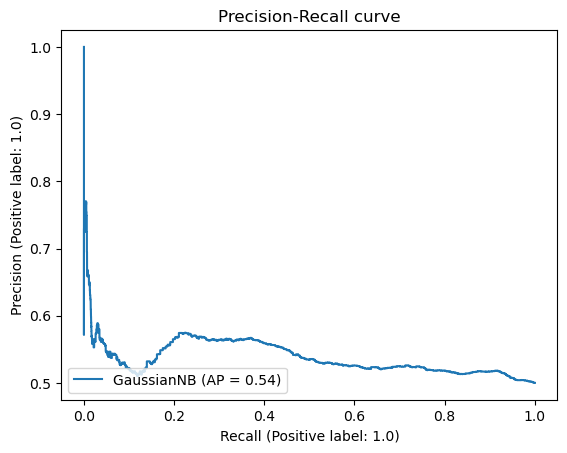

In [19]:

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, PrecisionRecallDisplay

# Train the Gaussian Naive Bayes classifier
clf = GaussianNB()
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)

# Print the classification report
print(classification_report(y_test, y_pred))

# Plot the precision-recall curve
display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
_ = display.ax_.set_title("Precision-Recall curve")


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(balanced_df.drop(columns=['ARR_DEL15']), balanced_df['ARR_DEL15'], test_size=0.2, stratify=balanced_df['ARR_DEL15'], random_state=0)

Accuracy: 0.5986422386504203
              precision    recall  f1-score   support

         0.0       0.60      0.61      0.60     51335
         1.0       0.60      0.59      0.60     51334

    accuracy                           0.60    102669
   macro avg       0.60      0.60      0.60    102669
weighted avg       0.60      0.60      0.60    102669

Wall time: 657 ms


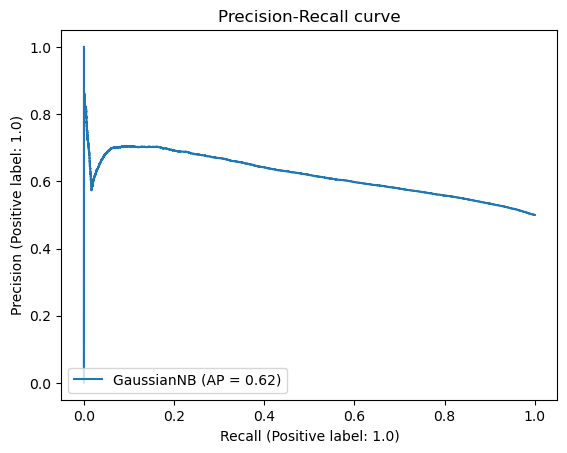

In [21]:

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, PrecisionRecallDisplay

# Train the Gaussian Naive Bayes classifier
clf = GaussianNB()
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)

# Print the classification report
print(classification_report(y_test, y_pred))

# Plot the Precision-Recall curve
display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
_ = display.ax_.set_title("Precision-Recall curve")


